In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from collections import namedtuple  
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion


In [2]:
env = gym.make('MountainCar-v0')
env.reset()

array([-0.48745376,  0.        ])

# Q learning N step

In [3]:
class Simple_Gradient_Decent:
    def __init__(self):
        self.w = None
        self.learning_rate = 1e-2
    
    def partial_fit(self, X, Y):
        if self.w is None:
            self.w = np.random.randn(X.shape[1])/np.sqrt(X.shape[1])
        self.w += self.learning_rate*(Y-X.dot(self.w)).dot(X)
    
    def predict(self, X):
        return X.dot(self.w)

In [4]:
class Model:
    def __init__(self, env, n_components=500):
        self.env = env
        self.standard = StandardScaler()
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        self.standard.fit(observation_examples)
        self.models = []
        self.featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
                ])
        example_features = self.featurizer.fit_transform(self.standard.transform(observation_examples))
        for i in range(env.action_space.n):
            model = Simple_Gradient_Decent()
            model.partial_fit(self.featurizer.transform(self.standard.transform( [env.reset()] )), [0])
            self.models.append(model)
    
    def update(self, s, a, G):
        X = self.featurizer.transform(self.standard.transform([s]))
        self.models[a].partial_fit(X, [G])
    
    def predict(self, s):
        X = self.featurizer.transform(self.standard.transform([s]))
        return np.stack([m.predict(X) for m in self.models]).T
    
    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [5]:
Transition = namedtuple('Transition', ['state', 'action', 'reward'])

In [6]:
def N_step_Q(env, model, eps, gamma, N=10):
    observation = env.reset()
    done = False
    total_rewards = 0
    states = []
    rewards = []
    multiplier = (gamma*np.ones(N))**np.arange(N)
    actions = []
    while not done:
        action = model.sample_action(observation, eps)
        obs, reward, done, info = env.step(action)
#         history.append(Transition(state=observation, action=action, reward=reward))
        states.append(observation)
        rewards.append(reward)
        actions.append(action)
        observation = obs
        if len(rewards)==N:
            returning = multiplier.dot(rewards)
            G = returning + (gamma**N)*np.max(model.predict(observation)[0])
            model.update(states[-N], actions[-N], G)
            rewards.pop(0)
            actions.pop(0)
            states.pop(0)
        total_rewards += reward
    if observation[0]>=0.5:
        while len(rewards) != 0:
            G = multiplier[:len(rewards)].dot(rewards)
            model.update(states[0], actions[0], G)
            rewards.pop(0)
            actions.pop(0)
            states.pop(0)
    else:
        while len(rewards) > 0:
            guess_rewards = rewards + [-1.0]*(N - len(rewards))
            G = multiplier.dot(guess_rewards)
            model.update(states[0], actions[0], G)
            rewards.pop(0)
            states.pop(0)
            actions.pop(0)
    return total_rewards

        
    

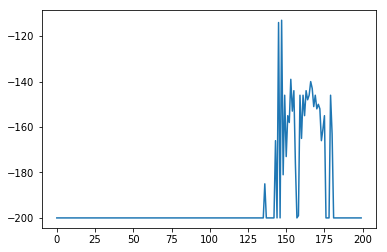

In [10]:
model =Model(env)

gamma = 0.99
episodes = 200
rewards = []
for i in range(episodes):
    eps = 1*(0.99**i)
    reward=N_step_Q(env=env, model=model, eps=eps, gamma=gamma)
    rewards.append(reward)
plt.plot(rewards)
plt.show()